1.Data analysis - Malta Airbnb

In [1]:
## Import libraries
import pandas as pd 
import numpy as np

import csv

#Natural Language processing 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
#from wordcloud import WordCloud

## Data visualization
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
## Load data
listings = pd.read_csv('./Data/listings.csv')
reviews = pd.read_csv('./Data/reviews.csv')
listings_summary = pd.read_csv('./Data/listings_summary.csv')

In [21]:
## Check detailed listings dataframe
listings.head()

,id,listing_url,scrape_id,last_searched,last_scraped,name,description,neighborhood_overview,picture_url,host_id,...,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,region_id,region_name,region_parent_id,region_parent_name,region_parent_parent_id,region_parent_parent_name,reviews_per_month
0,53988243,https://www.airbnb.com/rooms/53988243,20211228232058,2021-12-28,2021-12-30,Brand-new shared one-bedroom apartment (only g...,In the middle of San Julian and Sliema. Bus st...,NaN,https://a0.muscache.com/pictures/d5fd9439-76bc...,49911004,...,0,0,1,MT01253,San Gwann,NaN,NaN,NaN,NaN,NaN
1,39695529,https://www.airbnb.com/rooms/39695529,20211228232058,2021-12-28,2021-12-30,modern apartment,the apartment is very big and modern and its i...,mini market in 2 min walk <br />super market 1...,https://a0.muscache.com/pictures/e41a92fc-c010...,217804068,...,1,1,0,MT01310,Zejtun,NaN,NaN,NaN,NaN,NaN
2,11579194,https://www.airbnb.com/rooms/11579194,20211228232058,2021-12-28,2021-12-30,The Residence 03 - University area,The Residence is located within the upmarket H...,The Residence is located within the upmarket H...,https://a0.muscache.com/pictures/d7d822dd-3031...,57084556,...,0,7,0,MT01253,San Gwann,NaN,NaN,NaN,NaN,0.19
3,23363846,https://www.airbnb.com/rooms/23363846,20211228232058,2021-12-28,2021-12-30,"Full Air-conditioned, 2 Bedroom Apt.",An 80sqm 2 bedroom apartment in the South of M...,The apartment on top lives an Sicilian family....,https://a0.muscache.com/pictures/bca21e3d-f0e5...,31383964,...,1,0,0,MT01310,Zejtun,NaN,NaN,NaN,NaN,0.97
4,33903128,https://www.airbnb.com/rooms/33903128,20211228232058,2021-12-28,2021-12-30,Village Knights B&B - Valletta Room,"A luxury, authentic, house of character in the...","Just a 4 min walk up the road to the centre, o...",https://a0.muscache.com/pictures/94dc5710-ec97...,239349288,...,0,1,0,MT01407,Zebbug (Malta),NaN,NaN,NaN,NaN,NaN


In [3]:
## Check reviews dataframe
reviews.head(5)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,637763,2173360,2012-09-02,3250724,Naoufal,My stay here was à lot better than I expected!...
1,637763,2490468,2012-10-02,2678469,Joey,This was an absolutely delightful place to sta...
2,637763,2597919,2012-10-13,3679703,Katerina,My boyfriend and I stayed at Stefania's place ...
3,637763,4075716,2013-04-08,4180801,Philippe,very nice place to visit Malta. The house is c...
4,637763,4178698,2013-04-16,4902150,Roman,War alles gut bei Stefania. Sehr freundlich un...


In [4]:
## Check information about data type 

#listings.info()
## 8406 unique listings ID

reviews.info()
## 173180 comments

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173180 entries, 0 to 173179
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     173180 non-null  int64 
 1   id             173180 non-null  int64 
 2   date           173180 non-null  object
 3   reviewer_id    173180 non-null  int64 
 4   reviewer_name  173180 non-null  object
 5   comments       173093 non-null  object
dtypes: int64(3), object(3)
memory usage: 7.9+ MB


In [11]:
## Check for duplicates in listingd id
print("Number of unique listings id is:", listings.id.nunique())

## Unique number of host_id - 3678
print("Number of unique hosts id is:", listings.host_id.nunique())

## There are 8406 properties belonging to 3678 owners.


Number of unique listings id is: 8406
Number of unique hosts id is: 3678


In [42]:
## room_type vs. property_type
listings.room_type.nunique() #4
listings.property_type.nunique() #67
## choosing room_type, it's better grouped

listings.room_type.value_counts() 
## Entire home/apt seems to be the most common. It represents almost 65% of the sample, while private room 31%

Entire home/apt    5433
Private room       2614
Shared room         230
Hotel room          129
Name: room_type, dtype: int64

In [41]:
## for region_type
listings.region_name.nunique() #68

68

In [43]:
## Select columns to further analyse
necessary_columns = ['id', 'name', 'host_id',  'host_since', 'host_is_superhost', 'host_response_rate', 
                     'room_type', 'accommodates', 'minimum_nights', 'first_review', 'last_review', "price",
                     'review_scores_rating', 'calculated_host_listings_count', 'region_name', 'number_of_reviews']

## reviews_scores_rating was checked by looking at airbnb website

listings2 = listings.loc[:, listings.columns.isin(necessary_columns)]

In [44]:
## Convert price type to float
listings2.price = listings2.price.str.replace("[$, ]", "") ## remove '$' and ',' signs
listings2.price =listings2.price.astype('float') ## convert
listings2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8406 entries, 0 to 8405
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              8406 non-null   int64  
 1   name                            8405 non-null   object 
 2   host_id                         8406 non-null   int64  
 3   host_since                      8406 non-null   object 
 4   host_response_rate              6400 non-null   object 
 5   host_is_superhost               8406 non-null   object 
 6   room_type                       8406 non-null   object 
 7   accommodates                    8406 non-null   int64  
 8   price                           8406 non-null   float64
 9   minimum_nights                  8406 non-null   int64  
 10  number_of_reviews               8406 non-null   int64  
 11  first_review                    6414 non-null   object 
 12  last_review                     64

<ipython-input-44-83c5eeba5965>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  listings2.price = listings2.price.str.replace("[$, ]", "") ## remove '$' and ',' signs
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [29]:
## Descriptive statistics
dataDescrib = listings2.describe()
dataDescrib

,id,host_id,accommodates,price,minimum_nights,number_of_reviews,review_scores_rating,review_scores_value,calculated_host_listings_count
count,8.406000e+03,8.406000e+03,8406.000000,8406.000000,8406.000000,8406.000000,6414.000000,6339.000000,8406.000000
mean,3.262605e+07,1.413875e+08,4.051511,100.818463,4.507733,20.601951,4.608499,4.641647,28.538663
std,1.547576e+07,1.205963e+08,2.524990,134.170182,23.695342,37.068934,0.690997,0.472872,81.324078
min,5.018800e+04,5.900800e+04,1.000000,8.000000,1.000000,0.000000,0.000000,1.000000,1.000000
25%,2.016570e+07,3.039001e+07,2.000000,44.000000,1.000000,1.000000,4.530000,4.540000,1.000000
50%,3.496828e+07,1.184890e+08,4.000000,70.000000,2.000000,5.000000,4.800000,4.750000,3.000000
75%,4.718476e+07,2.225276e+08,6.000000,118.000000,3.000000,23.000000,5.000000,4.930000,11.000000
max,5.403093e+07,4.362538e+08,16.000000,4500.000000,1000.000000,427.000000,5.000000,5.000000,380.000000


In [35]:
## Group by property type
listings2.groupby(['room_type'])['number_of_reviews'].describe()

,count,mean,std,min,25%,50%,75%,max
room_type,,,,,,,,
Entire home/apt,5433.0,23.991533,39.584150,0.0,1.0,8.0,29.00,427.0
Hotel room,129.0,8.682171,12.584703,0.0,1.0,4.0,10.00,63.0
Private room,2614.0,15.527544,32.646781,0.0,0.0,2.0,15.00,306.0
Shared room,230.0,4.891304,11.030779,0.0,0.0,1.0,3.75,96.0


In [32]:
## Top neighbourhoods by number of reviews


,count,mean,std,min,25%,50%,75%,max
region_name,,,,,,,,
Attard,16.0,6.625000,12.904134,0.0,0.75,1.5,4.25,43.0
Balzan,16.0,21.937500,41.251212,0.0,0.00,2.5,15.75,148.0
Birgu,74.0,37.945946,48.129361,0.0,5.00,18.5,54.00,215.0
Birkirkara,117.0,12.316239,21.924891,0.0,0.00,3.0,14.00,125.0
Birzebbugia,72.0,22.291667,44.215999,0.0,1.00,4.5,25.75,296.0
...,...,...,...,...,...,...,...,...
Zabbar,29.0,17.965517,36.816614,0.0,0.00,3.0,20.00,163.0
Zebbug (Ghawdex),315.0,20.403175,32.042160,0.0,0.00,7.0,26.50,216.0
Zebbug (Malta),51.0,12.549020,29.712835,0.0,0.00,1.0,8.50,139.0


In [ ]:
## Top 10 neighbourhoods by average host score

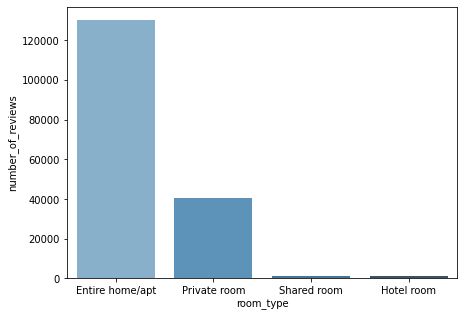

In [68]:
room_types_reviews = listings2.groupby(['room_type']).agg({'number_of_reviews': pd.Series.sum})
#room_types_reviews = listings.groupby(['room_type']).size().sort_values(ascending=False)
room_types_reviews = room_types_reviews.reset_index()
room_types_reviews.sort_values("number_of_reviews", ascending=False, inplace=True)
#room_types_reviews.info()

plt.figure(figsize=(7,5))
p1 = sns.barplot(x = 'room_type', y = "number_of_reviews", data = room_types_reviews, palette="Blues_d")


In [87]:
## Data binning - price
# Price ranges (8$ - 4500$)

#bins = np.linspace(listings2.price.min(), listings2.price.max(), 3)
labels = [1,2,3,4,5,6]
#bins = [8, 100, 250, 500, 1000, 4500] ## initial vals.
bins = [8, 50, 100, 300, 500, 1000, 4500]
df = listings2
df['bin_cut'] = pd.cut(df.price, bins=bins, labels = labels, include_lowest=True)


<ipython-input-87-3b9290eff051>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bin_cut'] = pd.cut(df.price, bins=bins, labels = labels, include_lowest=True)


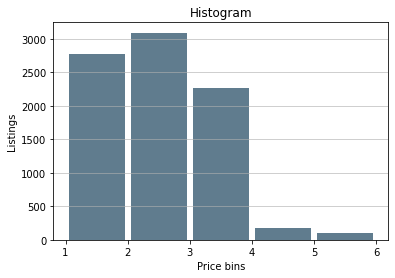

In [88]:
#plt.hist(df['bin_cut'], bins =5)

plt.hist(df['bin_cut'], bins=5, rwidth=0.9,
                   color='#607c8e')
plt.title('Histogram')
plt.xlabel('Price bins')
plt.ylabel('Listings')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [79]:
#df.bin_cut.value_counts()
bins = np.linspace(listings2.price.min(), listings2.price.max(), 6)
bins

array([   8. ,  906.4, 1804.8, 2703.2, 3601.6, 4500. ])

In [89]:
df.bin_cut.value_counts()

2    3093
1    2775
3    2263
4     178
5      71
6      26
Name: bin_cut, dtype: int64

In [ ]:
# import jenkspy
# breaks = jenkspy.jenks_breaks(df['Cupcake'], nb_class=3)
# df['bin_cut_break'] = pd.cut(df['Cupcake'] , bins=breaks, labels=labels, include_lowest=True)
# plt.hist(df['bin_cut_break'], bins=3)
# plt.show()

In [30]:
## Save column names in separate df to take a look at them
colnames_listingDf = np.array(listings.columns)
df_colnames = pd.DataFrame(data=colnames_listingDf)
df_colnames = df_colnames.rename(columns = {0: 'Colname'}, inplace=False)

In [21]:
## Check columns related to reviews from the listings df
reviews_cols = [col for col in listings.columns if 'review' in col]
print(reviews_cols)

['number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month']


In [ ]:
## thought of joining them, but we have multiple reviews on the same propriety

In [32]:
#df = reviewsDf.groupby('listing_id')['comments'].nunique()
## max comments no. = 425
## min comments no. = 1

## nunique returns a series. agg returns a df
df = reviews.groupby('listing_id').agg({'comments': pd.Series.nunique}) ##6428

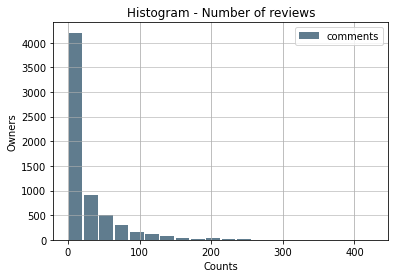

In [34]:
# 
size, scale = 1000, 10
df.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Histogram - Number of reviews')
plt.xlabel('Counts')
plt.ylabel('Owners')
plt.grid(axis='y', alpha=0.75)

In [6]:
## Select listings with >= 10 reviews
listings = listings[df.listings >= 20] ##1063

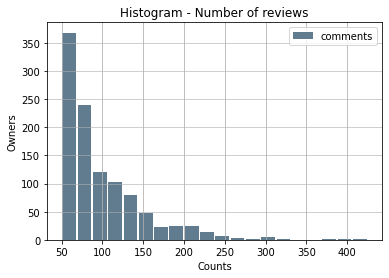

In [43]:
# Generate data on commute times.
size, scale = 1000, 10
#commutes = pd.Series(np.random.gamma(scale, size=size) ** 1.5)

df.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Histogram - Number of reviews')
plt.xlabel('Counts')
plt.ylabel('Owners')
plt.grid(axis='y', alpha=0.75)

In [9]:
## listing_id converted from index to column
df['listing_id'] = df.index

In [7]:
df.columns

Index(['comments'], dtype='object')

In [ ]:
ids = df['listing_id'].to_list()
#print(f"\nids:\n{ids}\ntype:{type(ids)}")

In [3]:
## Under 10 reviews dataframe
under_10_reviews = listings_summary[listings_summary.number_of_reviews < 10] ## 4997


In [4]:
listings_summary = listings_summary[listings_summary.number_of_reviews >= 10] ##3409

In [5]:
## drop 'id' column
reviews.drop('id', axis = 'columns', inplace=True)

## host_id, price, neighbourhood, room_type to join with
## Merge the reviews data frame with additional information about properties

reviews = reviews.rename(columns={'listing_id' : 'id'})
#reviews_full = pd.merge(reviews, listings_summary[['host_id', 'neighbourhood', 'room_type', 'price']], on = 'id', how = 'left') 

In [6]:
reviews = pd.merge(reviews, listings_summary[['id','host_id', 'host_name', 'neighbourhood', 'room_type', 'price']], how = 'left', on = "id") 

In [7]:
## Top 10 hosts from Malta based on number of reviews
top_10_hosts = reviews.groupby('host_id').size().sort_values(ascending = False).to_frame(name = 'reviews_number').head(10)
top_10_hosts

,reviews_number
host_id,
14163414.0,1543
3585451.0,1250
4214727.0,1235
577652.0,1210
2442805.0,1058
16573646.0,1048
1351697.0,891
219295979.0,869
1218900.0,867


In [ ]:
## Top 10 by id
reviews.groupby('host_id', 'id').size().sort_values(ascending = False).to_frame(name = 'reviews_number').head(10)

In [43]:
reviews.comments.values[5]

"Brilliant! While on vacation using Airbnb, I am looking for a clean comfortable room, good location and nice host. Stefania's triumphs in all three categories. Location can not be any better. It is 5-6 minutes walk of both sides of Sliema's water front; Sliema Ferry on one side is where all your bus and sea-bound tours start from (as well as the ferry to Valleta) and on the north side, border with San Julian, where there are even more eateries and night life. Rooms are large and spotlessly clean and bathrooms are newly remodeled. House is a typical local house tucked in a small, quiet residential area, that will remain quiet even in high tourism season (while being minutes away from the hassle and bustle). Upper floor provides the guest with total privacy and even their own small kitchen. Stefania is a gracious and superb host, and will sure take extremely good care of you. Highly recommended! Thanks Stefania for superb hospitality."

In [45]:
print(len(reviews.comments.values[5])) ## 946 words

946


In [25]:
reviews.dtypes

id                 int64
date              object
reviewer_id        int64
reviewer_name     object
comments          string
host_id          float64
host_name         object
neighbourhood     object
room_type         object
price            float64
dtype: object

In [9]:
reviews['comments'] = reviews['comments'].astype('string') ##convert to string. should try with object to see if it works.

In [10]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

In [11]:
import nltk
from nltk import sent_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/dianaionascu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [46]:
sentences = sent_tokenize(reviews.comments[5])

In [47]:
print(len(sentences))
sentences

11


['Brilliant!',
 'While on vacation using Airbnb, I am looking for a clean comfortable room, good location and nice host.',
 "Stefania's triumphs in all three categories.",
 'Location can not be any better.',
 "It is 5-6 minutes walk of both sides of Sliema's water front; Sliema Ferry on one side is where all your bus and sea-bound tours start from (as well as the ferry to Valleta) and on the north side, border with San Julian, where there are even more eateries and night life.",
 'Rooms are large and spotlessly clean and bathrooms are newly remodeled.',
 'House is a typical local house tucked in a small, quiet residential area, that will remain quiet even in high tourism season (while being minutes away from the hassle and bustle).',
 'Upper floor provides the guest with total privacy and even their own small kitchen.',
 'Stefania is a gracious and superb host, and will sure take extremely good care of you.',
 'Highly recommended!',
 'Thanks Stefania for superb hospitality.']

In [49]:
## Word tokenizing - transform the text into words
df_comment = reviews.comments[5]
words = word_tokenize(df_comment)

print(len(words)) 
words #187


187


['Brilliant',
 '!',
 'While',
 'on',
 'vacation',
 'using',
 'Airbnb',
 ',',
 'I',
 'am',
 'looking',
 'for',
 'a',
 'clean',
 'comfortable',
 'room',
 ',',
 'good',
 'location',
 'and',
 'nice',
 'host',
 '.',
 'Stefania',
 "'s",
 'triumphs',
 'in',
 'all',
 'three',
 'categories',
 '.',
 'Location',
 'can',
 'not',
 'be',
 'any',
 'better',
 '.',
 'It',
 'is',
 '5-6',
 'minutes',
 'walk',
 'of',
 'both',
 'sides',
 'of',
 'Sliema',
 "'s",
 'water',
 'front',
 ';',
 'Sliema',
 'Ferry',
 'on',
 'one',
 'side',
 'is',
 'where',
 'all',
 'your',
 'bus',
 'and',
 'sea-bound',
 'tours',
 'start',
 'from',
 '(',
 'as',
 'well',
 'as',
 'the',
 'ferry',
 'to',
 'Valleta',
 ')',
 'and',
 'on',
 'the',
 'north',
 'side',
 ',',
 'border',
 'with',
 'San',
 'Julian',
 ',',
 'where',
 'there',
 'are',
 'even',
 'more',
 'eateries',
 'and',
 'night',
 'life',
 '.',
 'Rooms',
 'are',
 'large',
 'and',
 'spotlessly',
 'clean',
 'and',
 'bathrooms',
 'are',
 'newly',
 'remodeled',
 '.',
 'House',
 'i

In [25]:
from nltk.probability import FreqDist

In [50]:
from nltk.probability import FreqDist

## Let's find the frequency
freq_words = FreqDist(words)

## Top 10 words
freq_words.most_common(10) ## a lot of punctuation marks and stop words.

[('and', 10),
 ('.', 9),
 (',', 7),
 ('a', 4),
 ('is', 4),
 ('the', 4),
 ('on', 3),
 ('Stefania', 3),
 ('in', 3),
 ('of', 3)]

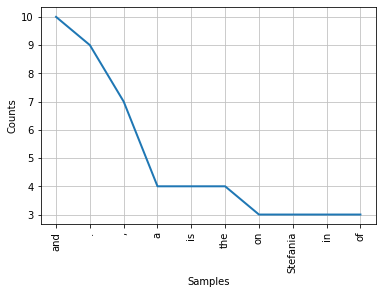

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [51]:
## Plot the word frequency

freq_words.plot(10)

In [52]:
## Remove punctuation marks
words_no_punct = []

for w in words:
    if w.isalpha():
        words_no_punct.append(w.lower())

print(words_no_punct)
print("\n")
print(len(words_no_punct)) ## 160!

['brilliant', 'while', 'on', 'vacation', 'using', 'airbnb', 'i', 'am', 'looking', 'for', 'a', 'clean', 'comfortable', 'room', 'good', 'location', 'and', 'nice', 'host', 'stefania', 'triumphs', 'in', 'all', 'three', 'categories', 'location', 'can', 'not', 'be', 'any', 'better', 'it', 'is', 'minutes', 'walk', 'of', 'both', 'sides', 'of', 'sliema', 'water', 'front', 'sliema', 'ferry', 'on', 'one', 'side', 'is', 'where', 'all', 'your', 'bus', 'and', 'tours', 'start', 'from', 'as', 'well', 'as', 'the', 'ferry', 'to', 'valleta', 'and', 'on', 'the', 'north', 'side', 'border', 'with', 'san', 'julian', 'where', 'there', 'are', 'even', 'more', 'eateries', 'and', 'night', 'life', 'rooms', 'are', 'large', 'and', 'spotlessly', 'clean', 'and', 'bathrooms', 'are', 'newly', 'remodeled', 'house', 'is', 'a', 'typical', 'local', 'house', 'tucked', 'in', 'a', 'small', 'quiet', 'residential', 'area', 'that', 'will', 'remain', 'quiet', 'even', 'in', 'high', 'tourism', 'season', 'while', 'being', 'minutes', 

In [53]:
freq_words = FreqDist(words_no_punct)
freq_words.most_common(10)

[('and', 10),
 ('a', 4),
 ('is', 4),
 ('the', 4),
 ('on', 3),
 ('stefania', 3),
 ('in', 3),
 ('of', 3),
 ('are', 3),
 ('even', 3)]

In [16]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dianaionascu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
from nltk.corpus import stopwords

In [19]:
## List of stopwords
stopwords = stopwords.words("english")
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [59]:
## Remove stopwords
clean_words = []
for w in words_no_punct:
    if w not in stopwords:
        clean_words.append(w)

print(clean_words)
print("\n") ## 93 words
print(len(clean_words))

['brilliant', 'vacation', 'using', 'airbnb', 'looking', 'clean', 'comfortable', 'room', 'good', 'location', 'nice', 'host', 'stefania', 'triumphs', 'three', 'categories', 'location', 'better', 'minutes', 'walk', 'sides', 'sliema', 'water', 'front', 'sliema', 'ferry', 'one', 'side', 'bus', 'tours', 'start', 'well', 'ferry', 'valleta', 'north', 'side', 'border', 'san', 'julian', 'even', 'eateries', 'night', 'life', 'rooms', 'large', 'spotlessly', 'clean', 'bathrooms', 'newly', 'remodeled', 'house', 'typical', 'local', 'house', 'tucked', 'small', 'quiet', 'residential', 'area', 'remain', 'quiet', 'even', 'high', 'tourism', 'season', 'minutes', 'away', 'hassle', 'bustle', 'upper', 'floor', 'provides', 'guest', 'total', 'privacy', 'even', 'small', 'kitchen', 'stefania', 'gracious', 'superb', 'host', 'sure', 'take', 'extremely', 'good', 'care', 'highly', 'recommended', 'thanks', 'stefania', 'superb', 'hospitality']


93


In [60]:
## Words frequency now:
freq_words = FreqDist(clean_words)
freq_words.most_common(10)


[('stefania', 3),
 ('even', 3),
 ('clean', 2),
 ('good', 2),
 ('location', 2),
 ('host', 2),
 ('minutes', 2),
 ('sliema', 2),
 ('ferry', 2),
 ('side', 2)]

In [12]:
bckUp = reviews

In [13]:
## Data preparation - comments column

#1. Remove empty comments #173180 obs. initially
reviews = reviews[reviews['comments'].notnull()]

#2. Convert to lower case
reviews['comments'] = reviews['comments'].str.lower()

#3. Remove numbers
reviews['comments'] = reviews['comments'].str.replace('\d+', '')

# reviews['comments'] = reviews['comments'].str.rstrip(string.digits)

## 4. Remove punctuation (regex method)
reviews.comments = reviews.comments.str.replace("[^\w\s]", "")

## 5. Replace double spaces with single space
reviews.comments = reviews.comments.str.replace('\s+', ' ')

<ipython-input-13-e96464625059>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews['comments'] = reviews['comments'].str.lower()
<ipython-input-13-e96464625059>:10: FutureWarning: The default value of regex will change from True to False in a future version.
  reviews['comments'] = reviews['comments'].str.replace('\d+', '')
<ipython-input-13-e96464625059>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews['comments'] = reviews['comments'].str.replace('\d+', '')
<ipython-input-13-e96464625059>:1

In [21]:
## Use nltk library to remove unecessary information
#stopwords = stopwords.words["english"]
reviews.comments = reviews.comments.apply(lambda x: " ".join([i for i in x.split()
                                            if i not in (stopwords)]))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [23]:
# reviews['comments'] = reviews['comments'].apply(lambda x: " ".join([i for i in x.split() 
#                                                       if i not in (stopwords)]))

<ipython-input-23-df6bb98c7a22>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews['comments'] = reviews['comments'].apply(lambda x: " ".join([i for i in x.split()


In [22]:
reviews.comments[5]

'brilliant vacation using airbnb looking clean comfortable room good location nice host stefanias triumphs three categories location better minutes walk sides sliemas water front sliema ferry one side bus seabound tours start well ferry valleta north side border san julian even eateries night life rooms large spotlessly clean bathrooms newly remodeled house typical local house tucked small quiet residential area remain quiet even high tourism season minutes away hassle bustle upper floor provides guest total privacy even small kitchen stefania gracious superb host sure take extremely good care highly recommended thanks stefania superb hospitality'

In [29]:
## Words frequency
freq_words = FreqDist(reviews.comments)
freq_words.most_common(10)

[('host canceled reservation days arrival automated posting', 1058),
 ('', 350),
 ('good', 161),
 ('perfect', 142),
 ('great', 128),
 ('great place', 119),
 ('nice place', 118),
 ('great location', 81),
 ('nice', 75),
 ('ok', 67)]

In [30]:
## Let's make it look nicer
feedback = reviews.comments.to_list()

vec = CountVectorizer().fit(feedback)
bag_of_words = vec.transform(feedback)
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]


cvec_df = pd.DataFrame.from_records(words_freq, columns= ['words', 'counts']).sort_values(by="counts", ascending=False)
cvec_df.head(10)

,words,counts
846,apartment,68343
35,great,66803
52,place,56453
0,stay,54290
813,de,47272
13,location,43135
31,us,42126
103,nice,40517
746,et,37771
143,clean,37076


In [33]:
import collections

words_freq2 = collections.Counter(feedback)
print("Most common positive words:", words_freq2.most_common(10))

Most common positive words: [('host canceled reservation days arrival automated posting', 1058), ('', 350), ('good', 161), ('perfect', 142), ('great', 128), ('great place', 119), ('nice place', 118), ('great location', 81), ('nice', 75), ('ok', 67)]


In [34]:
freq_words_df = pd.DataFrame(words_freq2.most_common(10),
                                     columns=["Word", "Frequency"])
print(freq_words_df)

                                                Word  Frequency
0  host canceled reservation days arrival automat...       1058
1                                                           350
2                                               good        161
3                                            perfect        142
4                                              great        128
5                                        great place        119
6                                         nice place        118
7                                     great location         81
8                                               nice         75
9                                                 ok         67


In [37]:
text = nltk.Text(feedback)
frequency = FreqDist(text)
print(frequency.most_common(10))

[('host canceled reservation days arrival automated posting', 1058), ('', 350), ('good', 161), ('perfect', 142), ('great', 128), ('great place', 119), ('nice place', 118), ('great location', 81), ('nice', 75), ('ok', 67)]


In [26]:
feedback = reviews.comments.to_list()
feedback2 = ' '.join(feedback) ##convert list into string
tokens = nltk.word_tokenize(feedback2) ## tokenize the string
frequency = FreqDist(tokens)
print(frequency.most_common(10))

[('apartment', 68343), ('great', 66803), ('place', 56453), ('stay', 54290), ('de', 47272), ('location', 43135), ('us', 42126), ('nice', 40517), ('et', 37771), ('clean', 37076)]


In [28]:
freq_words_df = pd.DataFrame(frequency.most_common(10),
                                     columns=["Word", "Frequency"])
freq_words_df

,Word,Frequency
0,apartment,68343
1,great,66803
2,place,56453
3,stay,54290
4,de,47272
5,location,43135
6,us,42126
7,nice,40517
8,et,37771
9,clean,37076


In [ ]:
## Plot
top_10 = frequency.most_common(10)
top_10 = pd.Series(dict(frequency))
fig, ax =plt.subplots(figsize = (10,10))

## Seaborn
plot_fig = sns.barplot(x = top_10.index, y = top_10.values, ax=ax)
plt.xticks(rotation=30)

In [29]:
## Top 10 hosts from Malta based on number of reviews
top_10_hosts

,reviews_number
host_id,
14163414.0,1543
3585451.0,1250
4214727.0,1235
577652.0,1210
2442805.0,1058
16573646.0,1048
1351697.0,891
219295979.0,869
1218900.0,867


In [ ]:
## De aflat:
## 1. Cate proprietati detin
## 2. Top cuvinte
## 3. Tip proprietate
## 4. Preturi
## 5. Interval de timp
## 6. review-uri per tip proprietate? cate ca si numar.
## 7. reviewuri per scor si proprietate? 
## 8. pers cu highest number of reviews & scor?
## 9. comp. cuvinte intre cei care au scor >4 si care au <=4.
## 10. sintagme populare
## 11. topic modelling https://www.analyticsvidhya.com/blog/2018/10/mining-online-reviews-topic-modeling-lda/
## 12. sentiment analysis https://livebook.manning.com/book/real-world-machine-learning/chapter-8/25

In [40]:
top_10_hosts.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 10 entries, 14163414.0 to 28733688.0
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   reviews_number  10 non-null     int64
dtypes: int64(1)
memory usage: 160.0 bytes


In [44]:
#top_10_hosts = top_10_hosts.reset_index()
top_10_hosts.host_id = top_10_hosts.host_id.astype('float64') ##convert to float64 to match.

In [46]:
top_10_hosts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   host_id         10 non-null     float64
 1   reviews_number  10 non-null     int64  
dtypes: float64(1), int64(1)
memory usage: 288.0 bytes


In [33]:
# necessary_columns = ['id', 'name', 'host_id', 'host_name',  'listing_id', 'host_since', 'host_is_superhost', 'host_response_rate', 'hostal_total_listings_count',
#                         'neighbourhood', 'property_type', 'accommodate', 'price', 'minimum_nights', 'first_review', 'last_review',
#                         'review_scores_rating', 'review_scores_value', 'calculated_host_listings_count', 'region_name']   
#   
necessary_columns = ['id', 'name', 'host_id',  'host_since', 'host_is_superhost', 'host_response_rate', 
                         'property_type', 'accommodates', 'minimum_nights', 'first_review', 'last_review',
                        'review_scores_rating', 'review_scores_value', 'calculated_host_listings_count', 'region_name']    

reviews2 = pd.merge(reviews, listings[necessary_columns], on = 'id', how = 'left')

In [61]:
x = np.array(top_10_hosts.host_id)
listings2 = listings.loc[listings['host_id'].isin(x)]
listings2 = listings2.loc[:, listings2.columns.isin(necessary_columns)]

array([1.41634140e+07, 3.58545100e+06, 4.21472700e+06, 5.77652000e+05,
       2.44280500e+06, 1.65736460e+07, 1.35169700e+06, 2.19295979e+08,
       1.21890000e+06, 2.87336880e+07])